# Property price prediction - 3rd possibility

## Preparing libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import qgrid
import missingno as msno

from sklearn.metrics import mean_absolute_error
from tqdm import tqdm 
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, cross_validate

import xgboost as xgb
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import eli5
import mlflow

## Reading data

In [2]:
ls ../input/

big_train_warsaw_property.h5  train_data.h5@
test_warsaw_property.h5       train_warsaw_property.h5


In [30]:
df_train = pd.read_hdf("../input/train_warsaw_property.h5")
df_test = pd.read_hdf("../input/test_warsaw_property.h5")

df = pd.concat([df_train, df_test])
del df_train, df_test
gc.collect()

df.shape

(60222, 53)

## Feature engineering

In [31]:
def feature_engineering(df):

    df["area_num"] = df["area"].map(lambda x: x.split("m")[0].replace(" ", "").replace(",", ".")).astype("float")
    area_num_99 = np.percentile(df["area_num"], 99)
    df["area_norm"] = df["area_num"].map(lambda x: x if x <= area_num_99 else area_num_99  )
    

    df["price_m2"] = df["price"] / df["area_num"]
    
    for i in range(5):
        df["loc{}".format(i)] = df["location"].map(lambda x: x[i] if len(x) > i else "")

    df['loc01'] = df['loc0'] + df['loc1']
    df['loc012'] = df['loc0'] + df['loc1'] + df['loc2']
    df['loc12'] = df['loc1'] + df['loc2']
    
    return df

In [32]:
df_fe = feature_engineering(df.copy())

In [33]:
df_train = df_fe[ df_fe["price"].notnull() ]

In [34]:
price_loc0 = df_train.groupby("loc0")["price_m2"].agg(["mean", "median"])
price_loc0

,mean,median
loc0,,
dolnośląskie,5772.430638,6000.000000
kujawsko-pomorskie,4891.710918,4839.523053
lubelskie,5368.469299,5489.999879
lubuskie,3770.827881,3732.751675
mazowieckie,8930.811198,8460.797486
małopolskie,8146.889706,7555.555556
opolskie,3952.056959,4123.076923
podkarpackie,5037.863056,4993.731951
podlaskie,4943.757117,4761.029412


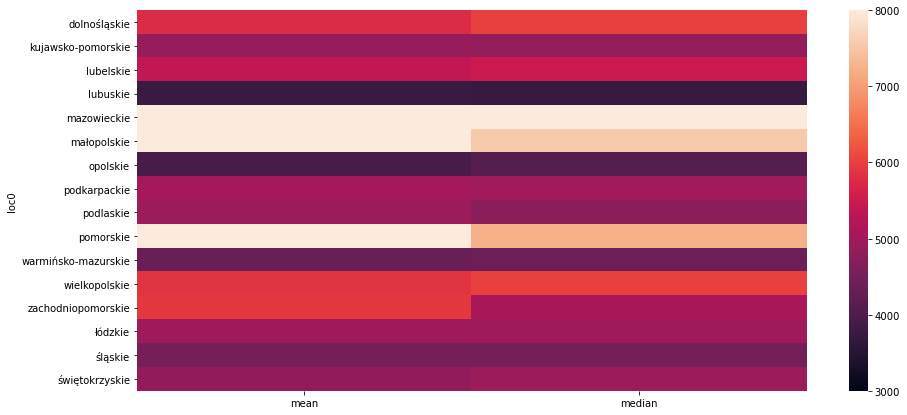

In [35]:
def plot_heatmap(df, vmin, vmax):
    plt.figure(figsize=(15, 7))
    sns.heatmap(df, vmin=vmin, vmax=vmax);
    
plot_heatmap(price_loc0, vmin=3000, vmax=8000)    

In [36]:
price_loc1 = df_train.groupby('loc1').filter(lambda x: len(x) > 100).groupby("loc1")["price_m2"].agg(["mean", "median"])
price_loc1

,mean,median
loc1,,
Białystok,5154.068665,5000.000000
Bielsko-Biała,4516.669126,4600.000000
Bydgoszcz,5198.044392,5011.764706
Częstochowa,4219.660651,4226.795321
Gdańsk,8607.056175,7776.000176
Gdynia,8951.534858,7936.640451
Gliwice,4814.485600,4941.990183
Katowice,5574.960944,5607.843137
Kielce,4969.602583,5000.000000


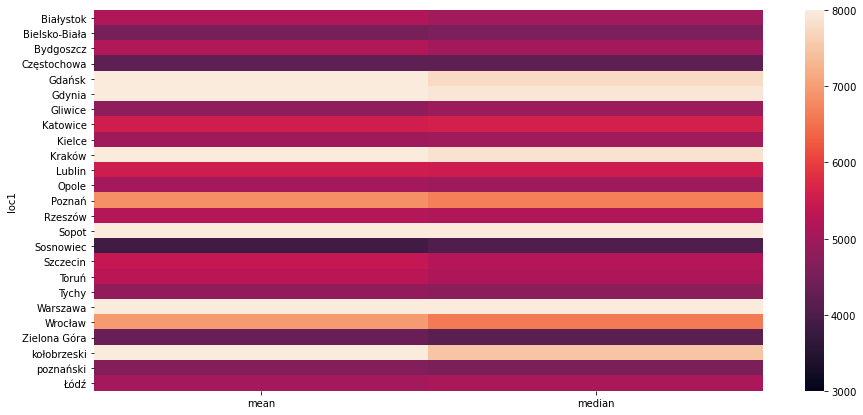

In [37]:
plot_heatmap(price_loc1, vmin=3000, vmax=8000)  

In [38]:
price_loc012 = df_train.groupby('loc012').filter(lambda x: len(x) > 100).groupby("loc012")["price_m2"].agg(["mean", "median"])
price_loc012

,mean,median
loc012,,
dolnośląskieWrocławKrzyki,6732.734536,6531.645570
mazowieckieWarszawaBiałołęka,6355.378726,6314.317673
mazowieckieWarszawaMokotów,11060.912023,10508.474576
mazowieckieWarszawaŚródmieście,13794.276088,12101.984310
małopolskieKrakówKrowodrza,8403.958335,8111.111111
małopolskieKrakówStare Miasto,11623.159461,11274.750450
wielkopolskiePoznańGrunwald,6687.205598,6436.053436
wielkopolskiePoznańWinogrady,7347.912769,7191.584778
zachodniopomorskiekołobrzeskiKołobrzeg,8564.914794,7960.186625


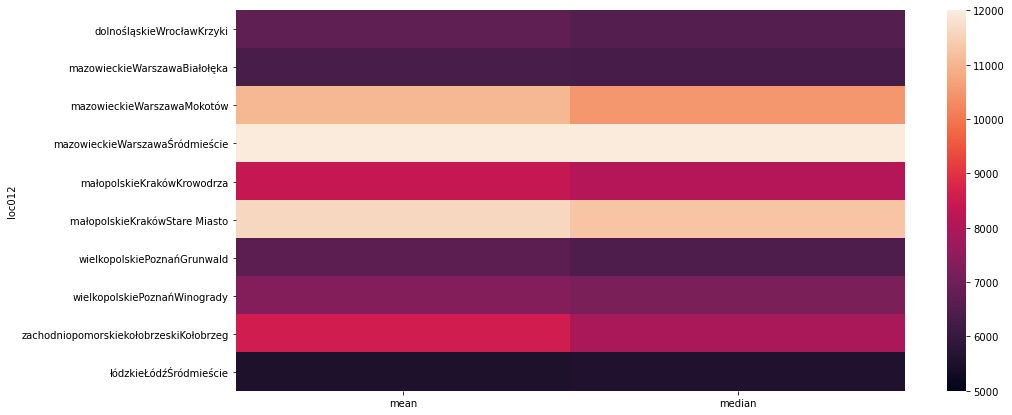

In [39]:
plot_heatmap(price_loc012, vmin=5000, vmax=12000)  

In [40]:
def add_price_m2_by_loc(df, item_dict, loc_num):
    df["price_m2_mean_{}".format(loc_num)] = df[loc_num].map(lambda x: item_dict["mean"].get(x) )
    df["price_m2_median_{}".format(loc_num)] = df[loc_num].map(lambda x: item_dict["median"].get(x) )

    
    df["diff_price_m2_mean_{}".format(loc_num)] = df["price_m2_mean_{}".format(loc_num)] - df["price_m2"]
    df["diff_price_m2_median_{}".format(loc_num)] = df["price_m2_median_{}".format(loc_num)] - df["price_m2"]
    
    
df_cp = df_fe[ ["id", "loc0", "loc1", "loc2", "loc012", "price", "price_m2", "area_num"] ].copy()

add_price_m2_by_loc(df_cp, price_loc0.to_dict(), "loc0")
add_price_m2_by_loc(df_cp, price_loc1.to_dict(), "loc1")
add_price_m2_by_loc(df_cp, price_loc012.to_dict(), "loc012")

train_cp = df_cp[ df_cp["price"].notnull() ].copy()
test_cp = df_cp[ df_cp["price"].isnull() ].copy()

loc0
null in train, 0, ~0.0%
null in test, 0, ~0.0%
price_m2_mean_loc0 6293.929622961292
diff_price_m2_mean_loc0 -3.2834930252864762e-12
price_m2_median_loc0 6042.399395905228
diff_price_m2_median_loc0 -251.53022705606742
loc1
null in train, 3781, ~27.11%
null in test, 12522, ~27.06%
price_m2_mean_loc1 7011.60626107301
diff_price_m2_mean_loc1 -1.7177157460200888e-14
price_m2_median_loc1 6640.5865984703
diff_price_m2_median_loc1 -371.01966260270905
loc012
null in train, 12613, ~90.44%
null in test, 42047, ~90.86%
price_m2_mean_loc012 8668.088226841277
diff_price_m2_mean_loc012 -7.254140649823056e-13
price_m2_median_loc012 8254.872135902553
diff_price_m2_median_loc012 -413.21609093872615


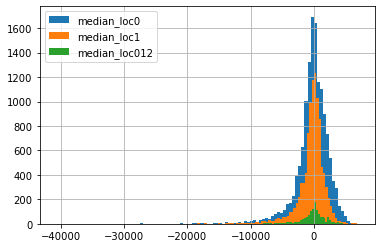

In [41]:
for loc_num in ["loc0", "loc1", "loc012"]:
    print(loc_num)

    train_null = train_cp[ train_cp["price_m2_mean_{}".format(loc_num)].isnull() ].shape[0]
    print("null in train, {}, ~{}%".format(train_null, np.round(train_null / train_cp.shape[0] * 100, 2) ))
    test_null = test_cp[ test_cp["price_m2_mean_{}".format(loc_num)].isnull() ].shape[0]
    print("null in test, {}, ~{}%".format( test_null, np.round(test_null / test_cp.shape[0] * 100, 2) ))

    train_cp["diff_price_m2_median_{}".format(loc_num)].hist(bins=100, label="median_{}".format(loc_num)).legend(loc='best')
    
    print("price_m2_mean_{}".format(loc_num), train_cp["price_m2_mean_{}".format(loc_num)].mean())
    print("diff_price_m2_mean_{}".format(loc_num), train_cp["diff_price_m2_mean_{}".format(loc_num)].mean())

    print("price_m2_median_{}".format(loc_num), train_cp["price_m2_median_{}".format(loc_num)].mean())
    print("diff_price_m2_median_{}".format(loc_num), train_cp["diff_price_m2_median_{}".format(loc_num)].mean())

    
    print("="* 50)



In [42]:
locs = ["loc0", "loc1", "loc012"]
loc_feats = ["price_m2_mean_{}".format(x) for x in locs]
loc_feats += ["price_m2_median_{}".format(x) for x in locs]

loc_feats

['price_m2_mean_loc0',
 'price_m2_mean_loc1',
 'price_m2_mean_loc012',
 'price_m2_median_loc0',
 'price_m2_median_loc1',
 'price_m2_median_loc012']

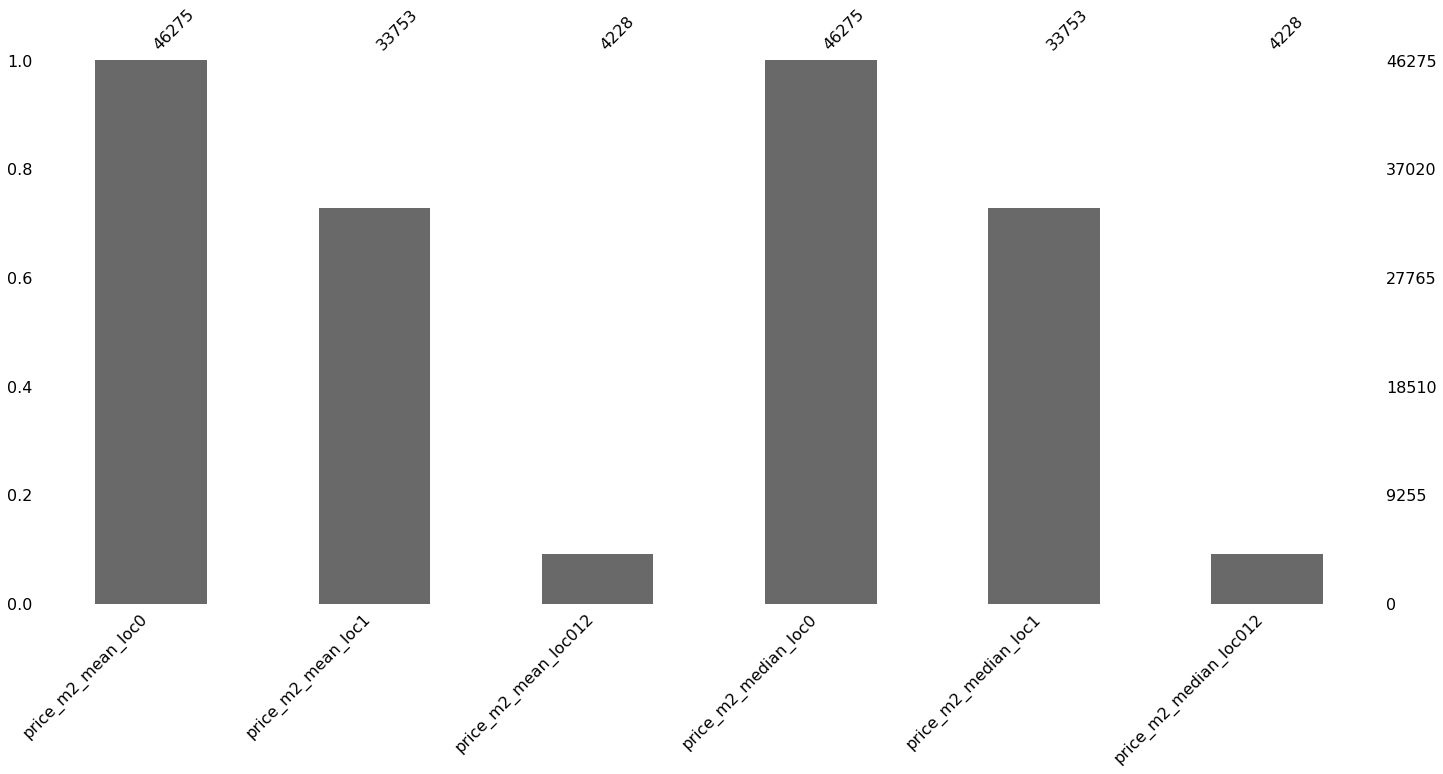

In [43]:
msno.bar(test_cp[ loc_feats ]);

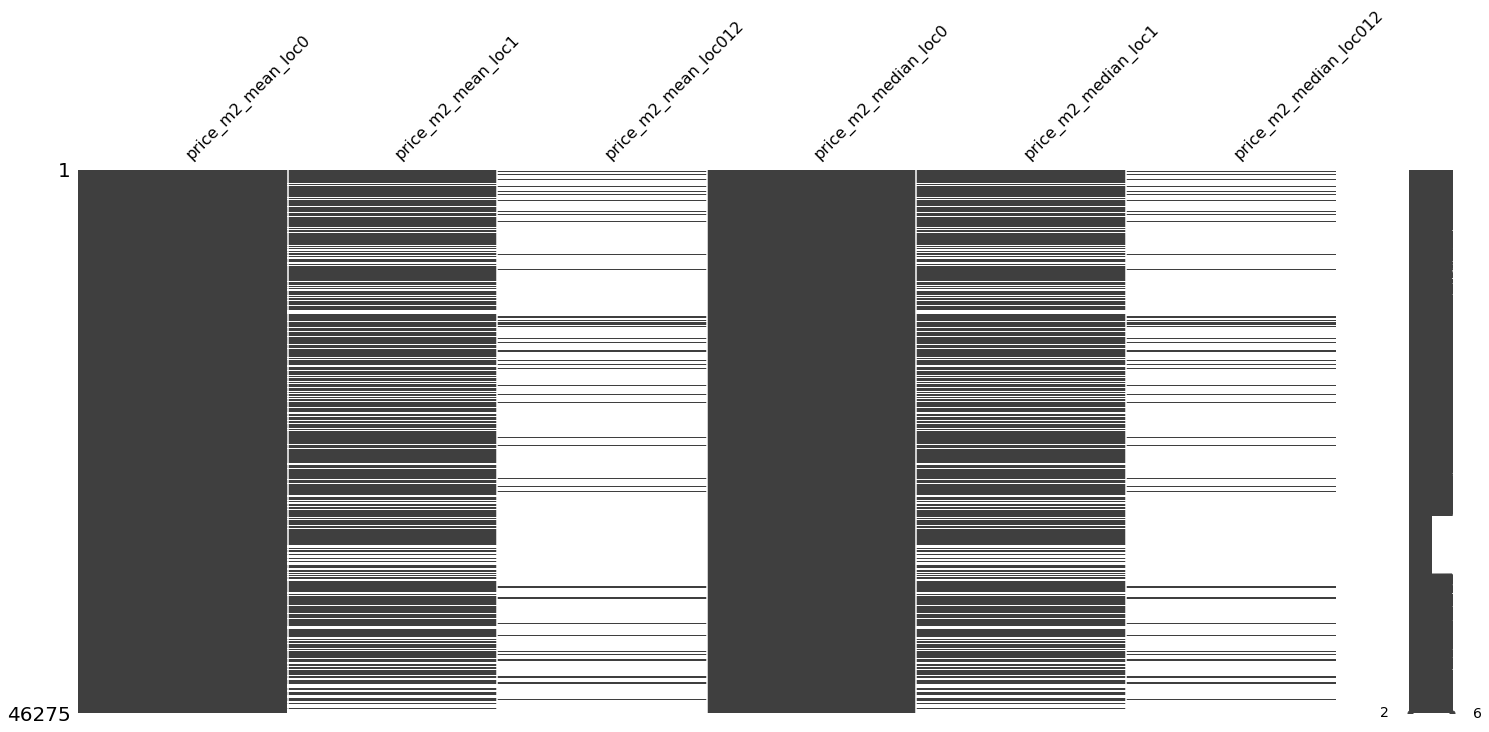

In [44]:
msno.matrix(test_cp[ loc_feats ]);

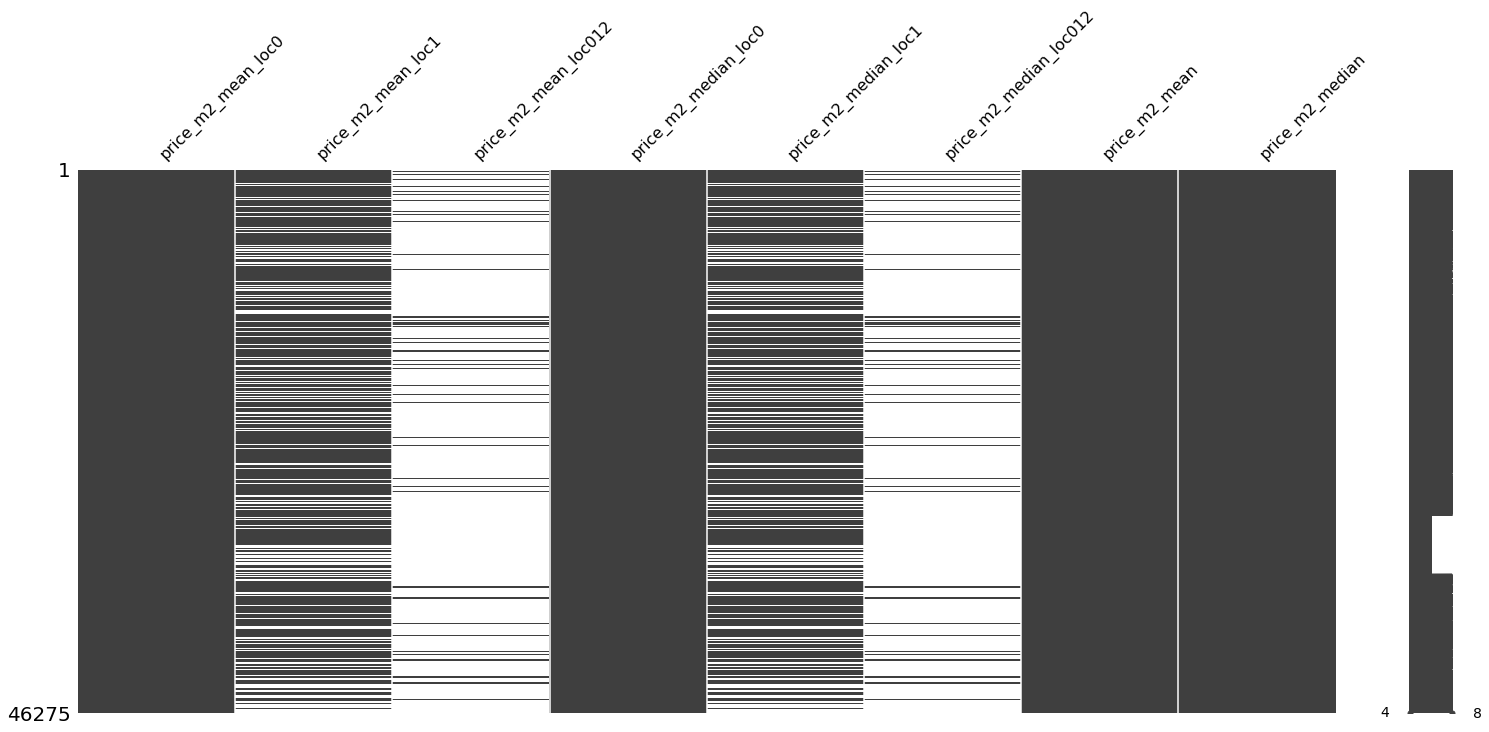

In [45]:
def fill_na_by_levels(agg, row):
    if pd.notnull(row["price_m2_{}_loc012".format(agg)]):
        return row["price_m2_{}_loc012".format(agg)]
    
    if pd.notnull(row["price_m2_{}_loc1".format(agg)]):
        return row["price_m2_{}_loc1".format(agg)]
            
    return row["price_m2_{}_loc0".format(agg)]

def fill_na_by_levels_mean(row): return fill_na_by_levels("mean", row)
def fill_na_by_levels_median(row): return fill_na_by_levels("median", row)

train_cp["price_m2_mean"] = train_cp.apply(fill_na_by_levels_mean, axis=1)
train_cp["price_m2_median"] = train_cp.apply(fill_na_by_levels_median, axis=1)

test_cp["price_m2_mean"] = test_cp.apply(fill_na_by_levels_mean, axis=1)
test_cp["price_m2_median"] = test_cp.apply(fill_na_by_levels_median, axis=1)

msno.matrix(test_cp[ loc_feats + ["price_m2_mean", "price_m2_median"] ]);

## Preparing model

In [46]:
black_list = ["id", "price", "price_m2", "price_median"]
feats = [x for x in df_fe.select_dtypes(["number", "boolean"]).columns if x not in black_list]

print(feats)
len(feats)

['is_private', 'piekarnik', 'garaż', 'monitoring / ochrona', 'rolety antywłamaniowe', 'kuchenka', 'taras', 'balkon', 'ogródek', 'dwupoziomowe', 'system alarmowy', 'pom. użytkowe', 'klimatyzacja', 'tarasy', 'teren zamknięty', 'internet', 'winda', 'telefon', 'pralka', 'piwnica', 'ochrona', 'telewizja kablowa', 'telewizor', 'lodówka', 'domofon / wideofon', 'oddzielna kuchnia', 'zmywarka', 'garaż/miejsce parkingowe', 'meble', 'drzwi / okna antywłamaniowe', 'plan zagospodarowania:', 'rooms', 'is_primary_market', 'area_num', 'area_norm']


35

In [47]:
train = df_fe[ df_fe["price"].notnull() ]
test = df_fe[ df_fe["price"].isnull() ].copy()

X_train = train[feats].values
y_train = train["price"].values
X_test =  test[feats].values

print(X_train.shape, X_test.shape)

(13947, 35) (46275, 35)


In [22]:
!mkdir -p ../outputs

In [49]:
model = xgb.XGBRegressor(max_depth=8, n_estimators=150, random_state=0)
model.fit(X_train, y_train)

"done"    

'done'

In [50]:
test["price"] = model.predict(X_test)
test[ ['id', 'price'] ].to_csv('../output/xgb_starter3.csv', index=False) 